In [93]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [174]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

In [175]:
# merger.convert_deaths_df()
df = merger.merge_deaths_df()

In [176]:
list(df["date"].unique())

[numpy.datetime64('2020-03-31T00:00:00.000000000')]

In [177]:
df_additional = merger.df["details"][["date","additional.infected"]].set_index("date")

In [178]:
df_tests = merger.show_kpi_hu()[["tests"]].reset_index()
df_tests["index"] = pd.to_datetime(df_tests["index"], format='%Y-%m-%d').dt.date
df_tests["additional.tests"] = df_tests.apply(
    lambda row: row["tests"]-df_tests[
        df_tests["index"]==row["index"] - pd.Timedelta(1, unit='D')
    ]["tests"].max(), 
    axis=1
)
df_tests = df_tests.set_index("index")

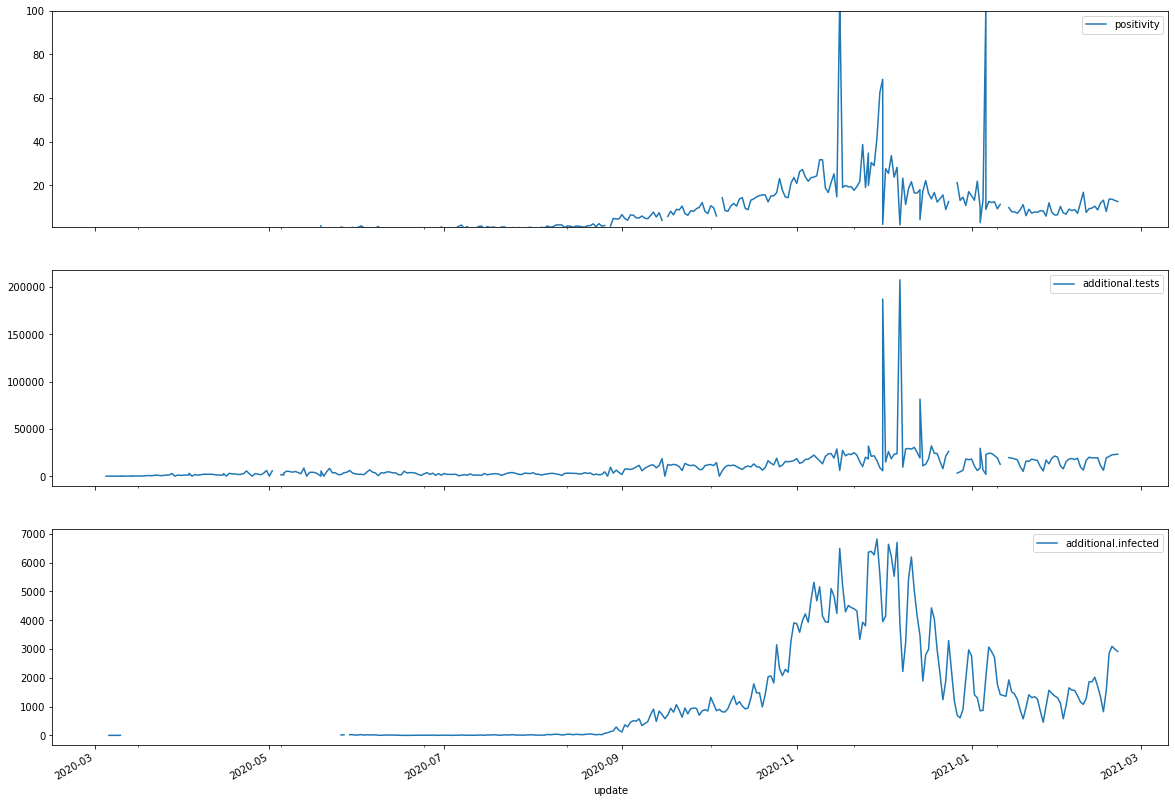

In [179]:
df_join = df_tests.join(df_additional).reset_index()
df_join["positivity"] = df_join["additional.infected"]/df_join["additional.tests"]*100
df_join["Country/Region"] = "HU"
df_join["update"] = df_join["index"]
(fig, ax) = plt.subplots(figsize=(20,15), nrows=3, sharex=True)
ax[0].set_ylim(1,100)
df_join.plot(x="update", y="positivity", ax=ax[0])
df_join.plot(x="update", y="additional.tests", ax=ax[1])
df_join.plot(x="update", y="additional.infected", ax=ax[2])
plt.show()

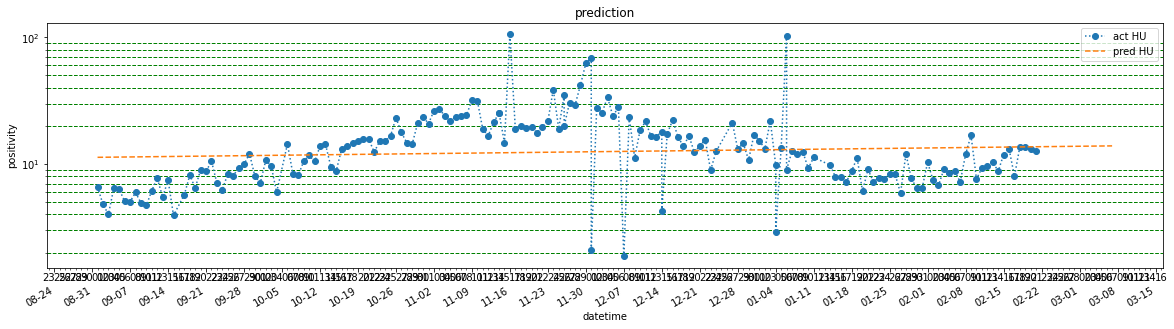

Coefficient of determination: {'HU': 0.007798108088023391}
Evolution factor per day: {'HU': 1.0}
Doubling in day(s): {'HU': 2.0}


,index,tests,additional.tests,additional.infected,positivity,Country/Region,update
390,2021-02-17,3414023.0,19339.0,1548.0,8.004550,HU,2021-02-17
391,2021-02-18,3434878.0,20855.0,2853.0,13.680173,HU,2021-02-18
392,2021-02-19,3457538.0,22660.0,3093.0,13.649603,HU,2021-02-19
393,2021-02-20,3480444.0,22906.0,2995.0,13.075177,HU,2021-02-20
394,2021-02-21,3503611.0,23167.0,2912.0,12.569603,HU,2021-02-21


In [180]:
tmpDf = md.DataProcessing.Analyse.start_analyse(
    df_join[
        (df_join["additional.tests"]>0) & (df_join["index"]>=pd.Timestamp("2020-09-01"))
    ].dropna(),
    ["HU"],
    "positivity", 
    "positivity"
)
df_join.tail()

# Check plausibility

In [181]:
# Details
selected_details_df = merger.df["details"][[
    "date", "additional.infected", "additional.deaths", 
    "cumulated.infected", "cumulated.recoveredFromHospital", 
    "onVentilator", "hospital", "active.infected"
]].copy()
selected_details_df.columns = [
    "date", "news.add.infected", "news.add.deaths", 
    "news.cum.infected", "news.cum.recovered", 
    "news.onVentilator", "news.hospital", "news.active"
]
selected_details_df["date"] = pd.to_datetime(selected_details_df["date"], format='%Y-%m-%d').dt.date
selected_details_df["news.add.recovered"] = selected_details_df.apply(
    lambda row: row["news.cum.recovered"] - selected_details_df[
        selected_details_df["date"]<row["date"]
    ]["news.cum.recovered"].max(), axis=1
)
selected_details_df = selected_details_df.set_index("date")

# KPI
selected_kpi_df = merger.show_kpi_hu()[["infected"]].copy().reset_index()
selected_kpi_df.columns = ["date", "kpi.cum.infected"]
selected_kpi_df["date"] = pd.to_datetime(selected_kpi_df["date"], format='%Y-%m-%d').dt.date
selected_kpi_df = selected_kpi_df.set_index("date")

selected_details_df.join(selected_kpi_df).tail()

,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,kpi.cum.infected
date,,,,,,,,,
2021-02-17,1548.0,94.0,391170,299989.0,321.0,4014.0,77250.0,1216.0,391170.0
2021-02-18,2853.0,104.0,394023,301363.0,332.0,4021.0,78625.0,1374.0,394023.0
2021-02-19,3093.0,110.0,397116,302689.0,352.0,4024.0,80282.0,1326.0,397116.0
2021-02-20,2995.0,107.0,400111,304680.0,351.0,4147.0,81179.0,1991.0,400111.0
2021-02-21,2912.0,47.0,403023,306621.0,366.0,4233.0,82103.0,1941.0,403023.0


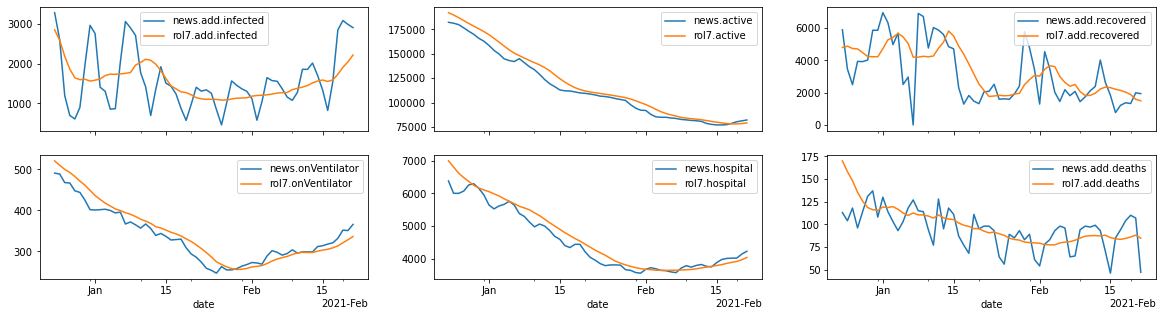

In [185]:
(fig, axs) = plt.subplots(figsize=(20,5), nrows=2, ncols=3, sharex=True)
plot_df = selected_details_df
configuration = {
    "add.infected":(0, 0), "onVentilator":(1,0),   # 1st col
    "active":(0,1),        "hospital":(1,1),       # 2nd col
    "add.recovered":(0,2), "add.deaths":(1,2)      # 3rd col
}
for category in configuration:
    plot_df["rol7.{}".format(category)] = plot_df.rolling(7).mean()[[f"news.{category}"]]
plot_df = plot_df.reset_index().tail(60)

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
for (category, position) in configuration.items():
    my_ax = axs[position[0]][position[1]]
    my_ax.xaxis.set_major_locator(locator)
    my_ax.xaxis.set_major_formatter(formatter)
    plot_df.plot(x="date", y="news.{}".format(category), ax=my_ax)
    plot_df.plot(x="date", y="rol7.{}".format(category), ax=my_ax)
plt.show()

In [183]:
#plot_df["add.infected"] = plot_df.apply(lambda row: plot_df[plot_df["date"]<], axis=1)
#plot_df.head()
plot_df.tail(10)

,date,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,rol7.add.infected,rol7.onVentilator,rol7.active,rol7.hospital,rol7.add.recovered,rol7.add.deaths
343,2021-02-12,1860.0,99.0,383735,289520.0,299.0,3828.0,80672.0,2386.0,1453.000000,297.428571,82324.142857,3723.142857,1965.142857,87.571429
344,2021-02-13,2020.0,93.0,385755,293542.0,299.0,3771.0,78577.0,4022.0,1518.571429,297.571429,81528.000000,3747.428571,2227.571429,87.142857
345,2021-02-14,1707.0,70.0,387462,296173.0,312.0,3755.0,77583.0,2631.0,1566.714286,300.571429,80662.428571,3772.714286,2344.285714,88.000000
346,2021-02-15,1337.0,46.0,388799,298008.0,314.0,3883.0,77039.0,1835.0,1592.000000,303.285714,79859.285714,3796.428571,2309.857143,85.285714
347,2021-02-16,823.0,85.0,389622,298773.0,318.0,3979.0,77012.0,765.0,1555.428571,305.285714,79117.714286,3823.142857,2213.000000,84.000000
348,2021-02-17,1548.0,94.0,391170,299989.0,321.0,4014.0,77250.0,1216.0,1593.857143,308.857143,78490.000000,3861.285714,2138.142857,83.428571
349,2021-02-18,2853.0,104.0,394023,301363.0,332.0,4021.0,78625.0,1374.0,1735.428571,313.571429,78108.285714,3893.000000,2032.714286,84.428571
350,2021-02-19,3093.0,110.0,397116,302689.0,352.0,4024.0,80282.0,1326.0,1911.571429,321.142857,78052.571429,3921.000000,1881.285714,86.000000
351,2021-02-20,2995.0,107.0,400111,304680.0,351.0,4147.0,81179.0,1991.0,2050.857143,328.571429,78424.285714,3974.714286,1591.142857,88.000000
352,2021-02-21,2912.0,47.0,403023,306621.0,366.0,4233.0,82103.0,1941.0,2223.000000,336.285714,79070.000000,4043.000000,1492.571429,84.714286


In [184]:
baseDf = pd.read_csv("data/map_data/map_dataframe_per_megye.csv", delimiter=",")[['date','region','confirmed']]
# Convert date column and add week/dayofweek
baseDf['date'] =  pd.to_datetime(baseDf['date'], format='%Y-%m-%d')
last_kpi = baseDf[baseDf["date"].isin(["2021-01-30","2021-02-06","2021-02-13","2021-02-20"])].pivot(
    index="region",
    columns="date",
    values="confirmed"
)
last_kpi.columns = ["d-21", "d-14", "d-7", "d"]
last_kpi["w_2"] = last_kpi["d-14"] - last_kpi["d-21"]
last_kpi["w_1"] = last_kpi["d-7"] - last_kpi["d-14"]
last_kpi["w_0"] = last_kpi["d"] - last_kpi["d-7"]
last_kpi["+_1.5"] = last_kpi["w_1"] - last_kpi["w_2"]
last_kpi["+_0.5"] = last_kpi["w_0"] - last_kpi["w_1"]
last_kpi

,d-21,d-14,d-7,d,w_2,w_1,w_0,+_1.5,+_0.5
region,,,,,,,,,
Baranya,12903,13294,13661,14054,391,367,393,-24,26
Borsod-Abaúj-Zemplén,20420,20937,21687,22714,517,750,1027,233,277
Budapest,67988,69585,71728,74365,1597,2143,2637,546,494
Bács-Kiskun,16914,17460,18008,18749,546,548,741,2,193
Békés,12274,12449,12664,12916,175,215,252,40,37
Csongrád,16747,17038,17431,18019,291,393,588,102,195
Fejér,14127,14449,14814,15376,322,365,562,43,197
Győr-Moson-Sopron,20484,20852,21431,22294,368,579,863,211,284
Hajdú-Bihar,20754,21204,21682,22451,450,478,769,28,291
